# Test with SAM

**Author:** Deeepwin   
**Date:** 02.07.2023   
**Description:** Testing with SAM, extract embedding and segmentation mask.
***



In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

## Installation

1. Clone SAM repo from https://github.com/facebookresearch/segment-anything
2. Download SAM model and copy to folder `models`
3. Clone this repo `git submodule add https://github.com/deeepwin/segment.git` into SAM `notebooks` folder 
4. Run this notebook

## Configuration

In [2]:
# go to project main folder
%cd ../..

/mnt/c/Users/WMART/Local_Repos/segment-anything/notebooks
/mnt/c/Users/WMART/Local_Repos/segment-anything


## Helpers

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Load SAM Model

In [4]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
sam = sam_model_registry["vit_h"](checkpoint="models/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

### Generate Embedding for Test Image

In [5]:
image = cv2.imread('notebooks/images/truck.jpg')
image.shape


(1200, 1800, 3)

In [6]:
# calculate embedding
predictor.set_image(image)

Notes on SAM Image Encoder:

- ImageEncoderViT is the backbone used to encode the image into image embeddings that allow for efficient mask prediction.  
- Is a light adaption of ViTDet backbone available at: https://github.com/facebookresearch/detectron2/blob/main/detectron2/modeling/backbone/vit.py 

From `image_encoder.py`:

```

class ImageEncoderViT(nn.Module):
    def __init__(
        self,
        img_size: int = 1024,
        patch_size: int = 16,
        in_chans: int = 3,
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        out_chans: int = 256,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_abs_pos: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        global_attn_indexes: Tuple[int, ...] = (),
    ) -> None:

        self.neck = nn.Sequential(
            nn.Conv2d(
                embed_dim,
                out_chans,
                kernel_size=1,
                bias=False,
            ),
            LayerNorm2d(out_chans),
            nn.Conv2d(
                out_chans,
                out_chans,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            LayerNorm2d(out_chans),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(x)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        x = self.neck(x.permute(0, 3, 1, 2))
```

In [7]:
# extract embedding
image_embedding = predictor.get_image_embedding().cpu().numpy()
np.save("notebooks/embeddings/truck_embedding.npy", image_embedding)

#  out_chans= 256, convolution output dim=64x64 
image_embedding.shape


(1, 256, 64, 64)

## Segment an Image

In [8]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [9]:
print(len(masks))
print(masks[0].keys())

81
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


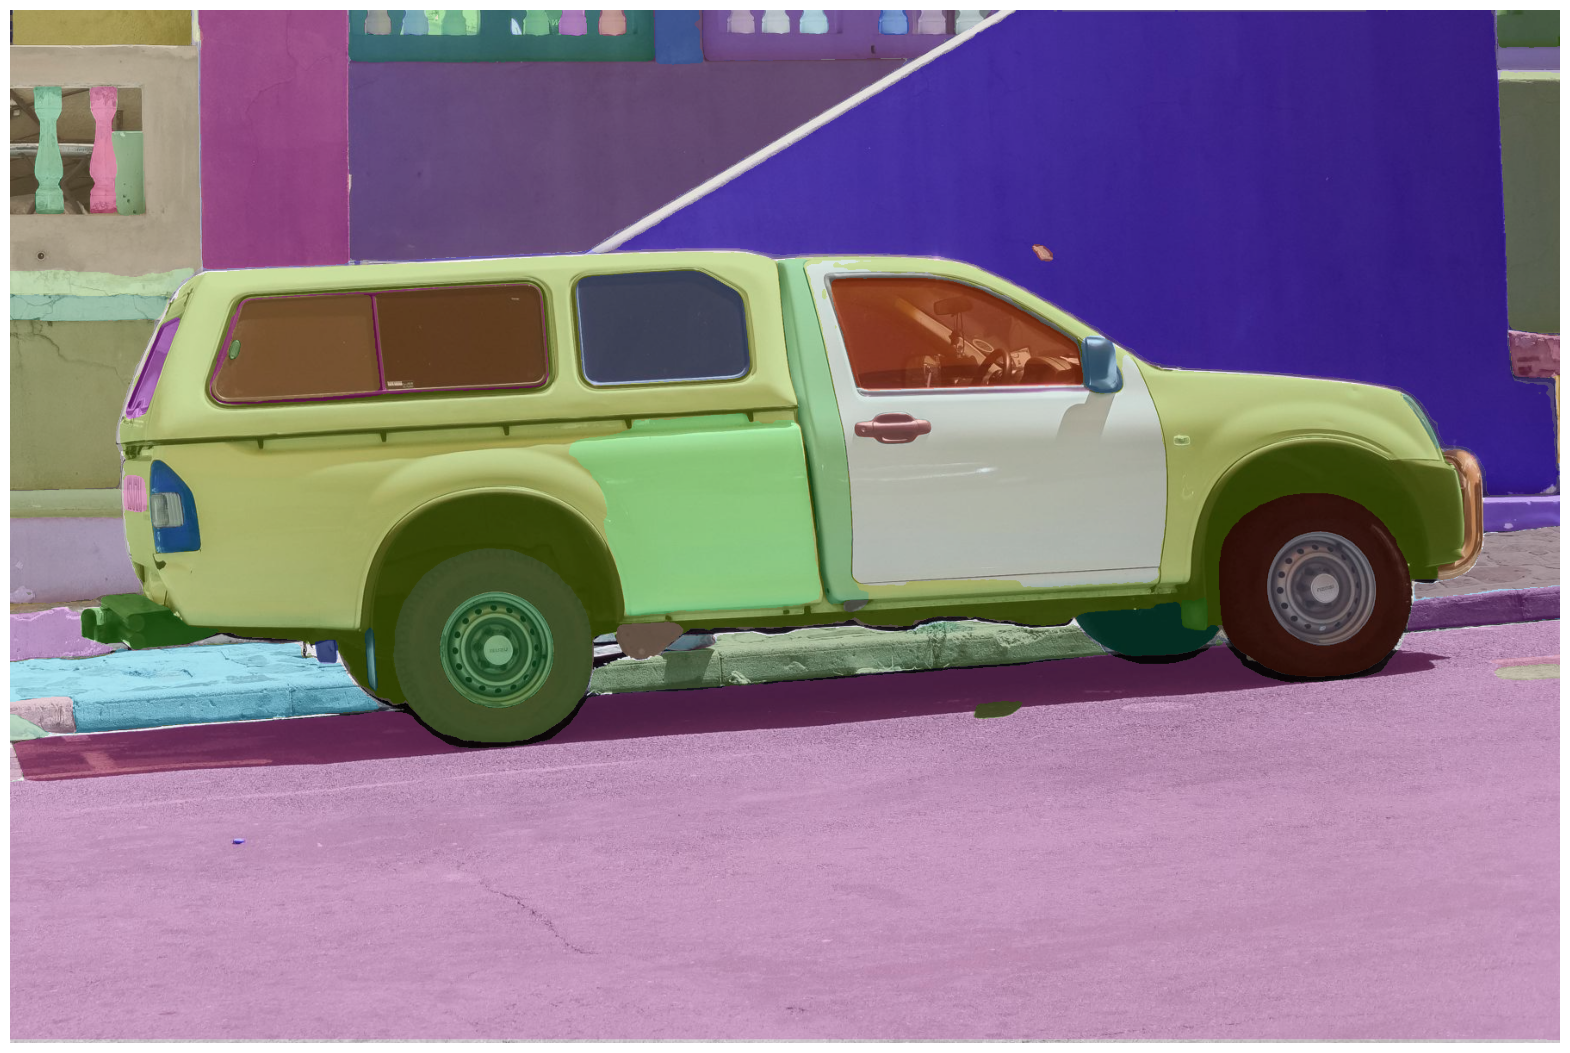

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Image Encoder Analytics

In [11]:
type(sam.image_encoder)

segment_anything.modeling.image_encoder.ImageEncoderViT

In [13]:
# check number of parameters and buffer 
model = sam.image_encoder
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
size_param_mb = (param_size) / 1024**2
print('Total model size: {:.3f}MB'.format(size_all_mb))
print('Parameter size: {:.3f}MB'.format(size_param_mb))

Total model size: 2430.062MB
Parameter size: 2430.062MB


In [22]:
# Total number of trainable parameters
nb_of_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameter: {}'.format(nb_of_trainable_params))

Number of trainable parameter: 637026048
